# Embedded Transformations within yt_xarray

data commonly in geographic coordinates.

## An example with 3D geographic data 



In [1]:
import xarray as xr
import yt_xarray
import yt
from yt_xarray import transformations as tf
from yt_xarray.utilities.logging import ytxr_log
import numpy as np 
import cartopy
from yt.visualization.volume_rendering.render_source import LineSource
from dask import delayed, compute
import shapely

In [2]:
yt.set_log_level(50)
ytxr_log.setLevel(50)

ds = yt_xarray.open_dataset("IRIS/wUS-SH-2010_percent.nc")
grid_resolution = (32, 32, 32)
gc = tf.GeocentricCartesian(radial_type='depth', r_o=6371., use_neg_lons=True)
ds_yt = tf.build_interpolated_cartesian_ds(
    ds,
    gc,
    fields = 'dvs' ,   
    grid_resolution = grid_resolution, 
    refine_grid=True,    
    refine_max_iters=2000,
    refine_min_grid_size=4,
    refine_by=4,
    interp_method='interpolate',
)


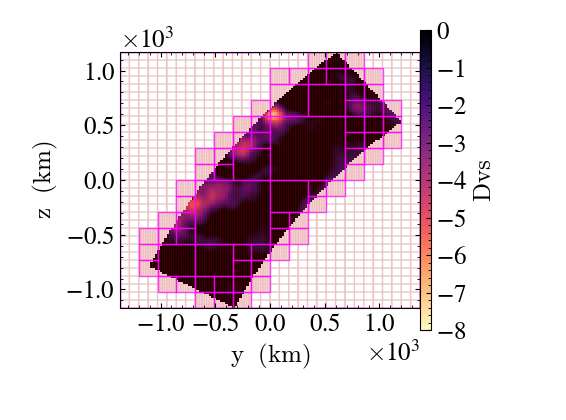

In [3]:
slc = yt.SlicePlot(ds_yt, 'x', ('stream', 'dvs'), window_size=(3,3))
slc.set_log(("stream", "dvs"), False)
slc.set_cmap(("stream", "dvs"), "magma_r")
slc.set_zlim(("stream", "dvs"), -8, 0)
slc.annotate_cell_edges(color=(1,0,0), alpha=0.3)
slc.annotate_grids(edgecolors=(1,0,1,1))
slc.show()

add a field to return abs(dvs<0)

In [4]:
def _slow_vels(field, data):    
    dvs = data['dvs'].copy()
    dvs[np.isnan(dvs)] = 0.0
    dvs[dvs>0] = 0.0
    return np.abs(dvs)

ds_yt.add_field(
    name=("stream", "slow_dvs"),
    function=_slow_vels,
    sampling_type="local",
)

volume render: use the yt_xarray transformer to easily create a yt `LineSource` in the correct cartesian coordinates. Using dask here to process NaturalEarth state boundaries accessed via cartopy

In [5]:
def process_state(state):
    linesegs = []
    if isinstance(state, shapely.geometry.polygon.Polygon):
        geoms_iter = [state,]
    elif isinstance(state, shapely.geometry.multipolygon.MultiPolygon):
        geoms_iter = state.geoms
    else:
        msg = f"Unexpected geometry type: {type(state)}"
        raise TypeError(msg)

    for geom in geoms_iter:
         linesegs = transform_geom_bounds(linesegs, geom.boundary.xy)        
    return linesegs

In [6]:
def transform_geom_bounds(linesegs, xy):
    lons = np.array(xy[0])
    lats = np.array(xy[1])
    
    x, y, z = gc.to_transformed(latitude=lats, 
                                longitude=lons, 
                                depth=0.0)
    
    for iseg in range(len(x)-1):            
        lineseg = [[x[iseg], y[iseg], z[iseg]], [x[iseg+1], y[iseg+1], z[iseg+1]]]
        linesegs.append(lineseg)
    return linesegs

In [7]:
state_segs = []
for s in cartopy.feature.STATES.geometries():    
    state_segs.append(delayed(process_state)(s))

state_segs = np.concatenate(compute(*state_segs))
colors = np.ones((state_segs.shape[0], 4))
colors[:,3] = 0.1
lsrc = LineSource(state_segs,colors=colors)

now ready for the volume rendering

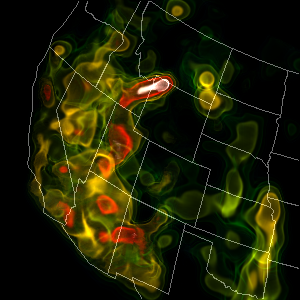

In [8]:
reg = ds_yt.region(ds_yt.domain_center, 
                   ds_yt.domain_left_edge, 
                   ds_yt.domain_right_edge)
sc = yt.create_scene(reg, field=('stream', 'slow_dvs'))
cam = sc.add_camera(ds_yt)

# transfer function 
source = sc[0]
source.tfh.set_bounds((0.1, 8))
source.tfh.set_log(True)

# add state outlines
sc.add_source(lsrc)

# adjust camera
cam.zoom(2)
cam.yaw(100*np.pi/180)
cam.roll(220*np.pi/180)
cam.rotate(30*np.pi/180)
cam.set_resolution((300,300))

sc.show(sigma_clip=5.)